In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


# **概要**
* KaggleのTelco customer churnのデータを使って解約者予測の分析を行う。
* このデータは元々IBMが提供していたデータと言われており、内容は電話会社の顧客に関するデータであり、解約するか否かを目的変数とした2値分類問題である。

# **Python Packageをインポートする**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
#省略なしでデータフレームを表示する
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)

# **EDA（探索的データ解析）**

In [4]:
#データセットを読み込み、先頭5行を確認する
df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
#データセットの各列の詳細情報を確認、欠損値がないことが分かる
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
#各列の内容を確認する
for i in df.columns:
    print(f"Unique {i}'s count: {df[i].nunique()}'")
    print(f"{df[i].unique()}\n")

Unique customerID's count: 7043'
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Unique gender's count: 2'
['Female' 'Male']

Unique SeniorCitizen's count: 2'
[0 1]

Unique Partner's count: 2'
['Yes' 'No']

Unique Dependents's count: 2'
['No' 'Yes']

Unique tenure's count: 73'
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]

Unique PhoneService's count: 2'
['No' 'Yes']

Unique MultipleLines's count: 3'
['No phone service' 'No' 'Yes']

Unique InternetService's count: 3'
['DSL' 'Fiber optic' 'No']

Unique OnlineSecurity's count: 3'
['No' 'Yes' 'No internet service']

Unique OnlineBackup's count: 3'
['Yes' 'No' 'No internet service']

Unique DeviceProtection's count: 3'
['No' 'Yes' 'No internet service']

Unique TechSupport's count: 3'
['No' 'Yes' 'No internet service']

Unique 

**＜各列の意味＞**

customerID：お客様ID

gender：顧客が男性か女性か

SeniorCitizen：顧客が高齢者かどうか（1、0）

Partner：顧客にパートナーがいるかどうか（はい、いいえ）

Dependents：顧客に扶養家族がいるかどうか（はい、いいえ）

tenure：顧客が契約していた月数

PhoneService：顧客が電話サービスを利用しているかどうか（はい、いいえ）

MultipleLines：顧客が複数の回線を利用しているかどうか（はい、いいえ、電話サービスなし）

InternetService：顧客がインターネットサービスプロバイダーを利用しているかどうか（DSL、光ファイバー、いいえ）

OnlineSecurity：顧客がオンラインセキュリティを利用しているかどうか（はい、いいえ、インターネットサービスなし）

OnlineBackup：顧客がオンラインバックアップを利用しているかどうか（はい、いいえ、インターネットサービスなし）

DeviceProtection：顧客がデバイス保護サービスを利用しているかどうか（はい、いいえ、インターネットサービスなし）

TechSupport：顧客が技術サポートを利用しているかどうか（はい、いいえ、インターネットサービスなし）

StreamingTV：顧客がストリーミングTVを利用しているかどうか（はい、いいえ、インターネットサービスなし）

StreamingMovies：顧客がストリーミング映画を利用しているかどうか（はい、いいえ、インターネットサービスなし）

Contract：顧客の契約期間（月々、1年、2年）

PaperlessBilling：顧客がペーパーレス請求を行っているかどうか（はい、いいえ）

PaymentMethod：顧客の支払い方法（電子小切手、郵送小切手、銀行振込（自動）、クレジットカード（自動））

MonthlyCharges：顧客に毎月請求される金額

TotalCharges：顧客に請求される合計金額

Churn：顧客が解約したかどうか（はい、いいえ）

Text(0.5, 1.0, 'Gender Distribution Among the Customers')

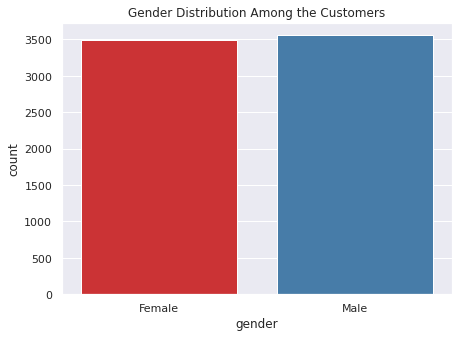

In [7]:
#性別の割合を視覚化
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(7,5)})

sns.countplot(x="gender", 
              data = df, 
              palette = 'Set1'
             ).set_title('Gender Distribution Among the Customers')

* 男性の顧客の方が女性の顧客に比べ僅かに多いが、特別差があるほどではない。

Text(0.5, 1.0, 'Distribution of Senior Citizens grouped by Partners')

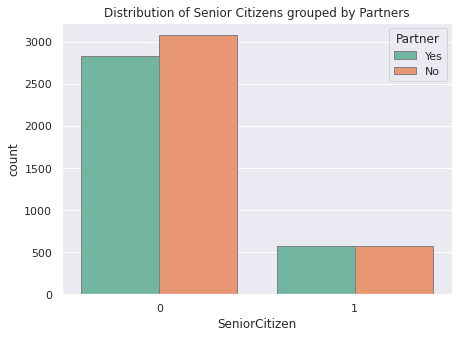

In [8]:
#高齢者とパートナー有無の割合を視覚化
sns.countplot(x = 'SeniorCitizen', hue = 'Partner', 
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Distribution of Senior Citizens grouped by Partners')

* 高齢者の顧客の割合は高齢者ではない顧客に比べ少なく、かつ高齢者の中でのパートナー有無に差は無い。

Text(0.5, 1.0, 'Customers with Dependents')

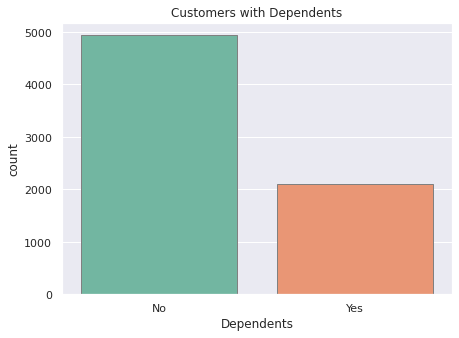

In [9]:
#扶養家族有無の割合を視覚化
sns.countplot(x = 'Dependents',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Customers with Dependents')

* 顧客の扶養家族の有無の割合は、扶養家族がいない顧客の方が多い。

Text(0.5, 1.0, 'Dependents and Partner Distribution among the Customers')

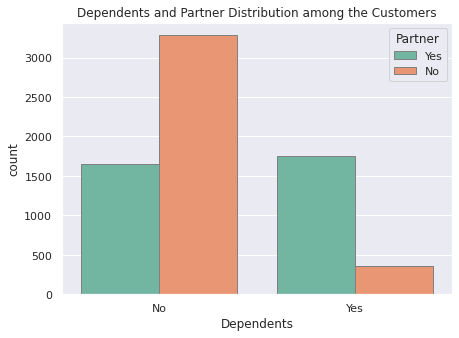

In [10]:
#扶養家族有無とパートナー有無の割合を視覚化
sns.countplot(x = 'Dependents', hue = 'Partner', 
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Dependents and Partner Distribution among the Customers')

* 扶養家族がいない顧客のパートナー有無の割合は、パートナーがいる顧客に比べ、パートナーがいない顧客の方が多い。

Text(0.5, 1.0, 'Dependents and Senior Citizen Distribution')

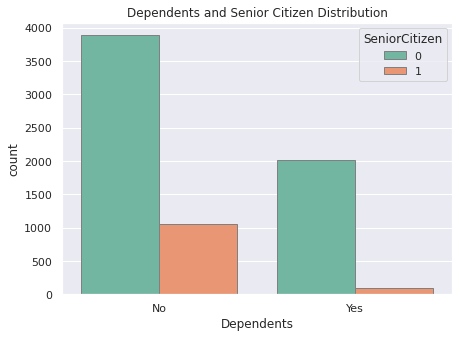

In [11]:
#扶養家族有無と高齢者の割合を視覚化
sns.countplot(x = 'Dependents', hue = 'SeniorCitizen', 
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Dependents and Senior Citizen Distribution')

* 高齢者の顧客のうち、扶養家族がいない顧客は扶養家族がいる顧客に比べ多い。（約10倍）
* 高齢者ではない顧客のうち、扶養家族がいない顧客は扶養家族がいる顧客に比べ多い。（約2倍）

Text(0.5, 1.0, 'Customers with Phone Service')

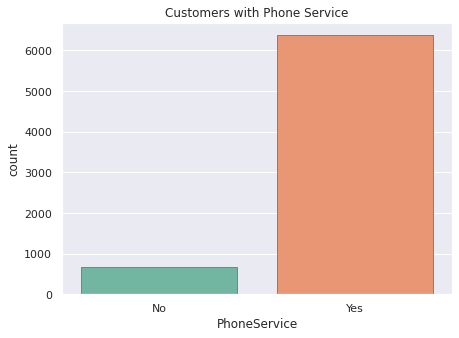

In [12]:
#電話サービス利用有無の割合を視覚化
sns.countplot(x = 'PhoneService', 
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Customers with Phone Service')

* 顧客の電話サービス利用有無の割合は、利用している顧客の方が多い。

Text(0.5, 1.0, 'Gender Distribution Among the Three Classes of Population')

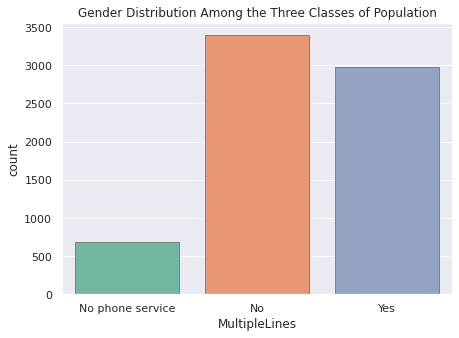

In [13]:
#複数回線の利用有無の割合を視覚化
sns.countplot(x = 'MultipleLines',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Gender Distribution Among the Three Classes of Population')

* 複数回線利用顧客に比べ、単一回線を利用している顧客の方が若干多い。

Text(0.5, 1.0, 'Phone Service and Multiple Lines')

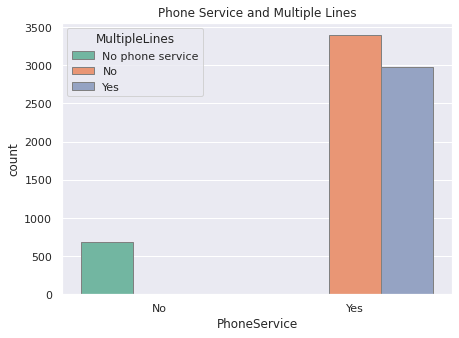

In [14]:
#電話サービス利用と複数回線利用の割合を視覚化
sns.countplot(x = 'PhoneService', hue = 'MultipleLines',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Phone Service and Multiple Lines')

* 上記同様、複数回線利用顧客に比べ、単一回線を利用している顧客の方が若干多い。

Text(0.5, 1.0, 'Internet Service')

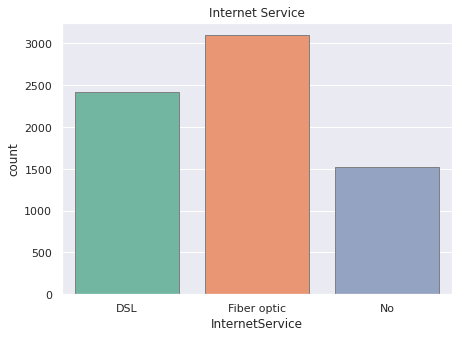

In [15]:
#インターネットサービスプロパイダーの割合を視覚化
sns.countplot(x = 'InternetService', 
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Internet Service')

* 光ファイバーを利用している顧客の方が、DSLを利用している顧客に比べ多い。

Text(0.5, 1.0, 'Online Security')

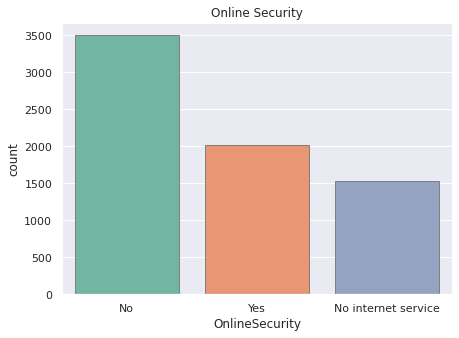

In [16]:
#オンラインセキュリティ利用の割合を視覚化
sns.countplot(x = 'OnlineSecurity', 
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Online Security')

* オンラインセキュリティを利用していない顧客の方が、利用している顧客に比べ多い。

Text(0.5, 1.0, 'Internet Service and Online Security')

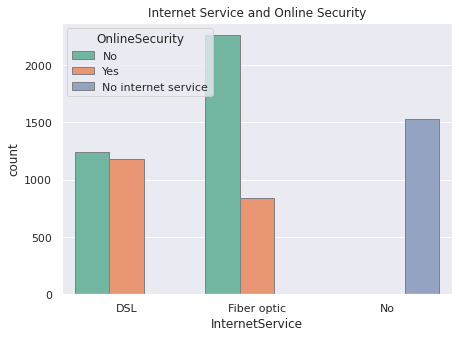

In [17]:
#インターネットサービス利用とオンラインセキュリティ利用の割合を視覚化
sns.countplot(x = 'InternetService', hue = 'OnlineSecurity',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Internet Service and Online Security')

* 光ファイバー利用顧客のうち、オンラインセキュリティを利用していない顧客の割合は多い。

Text(0.5, 1.0, 'Internet Service and Online Backup')

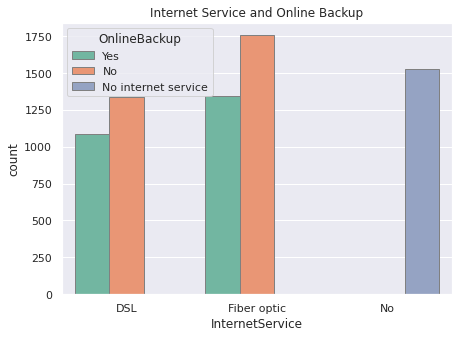

In [18]:
#インターネットサービス利用とオンラインバックアップ利用の割合を視覚化
sns.countplot(x = 'InternetService', hue = 'OnlineBackup',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Internet Service and Online Backup')

* 光ファイバー・DSLともに、オンラインバックアップを利用していない顧客の方が多い。

Text(0.5, 1.0, 'Internet Service and Device Protection')

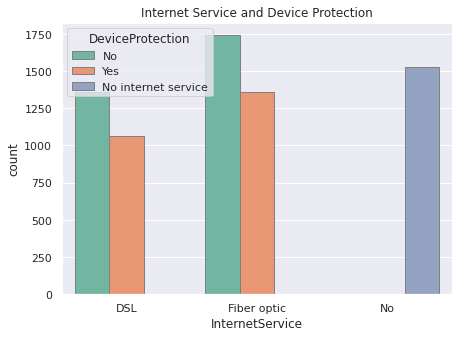

In [19]:
#インターネットサービス利用とデバイス保護サービス利用の割合を視覚化
sns.countplot(x = 'InternetService', hue = 'DeviceProtection',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Internet Service and Device Protection')

* 光ファイバー・DSLともに、デバイス保護サービスを利用していない顧客の方が多い。

Text(0.5, 1.0, 'Internet Service and Tech Support')

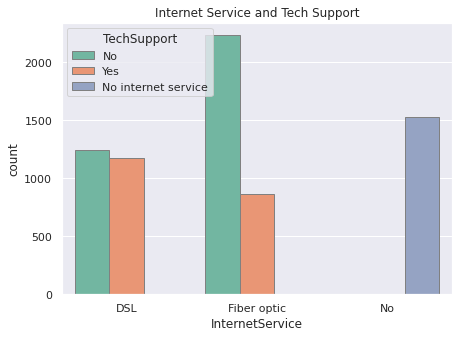

In [20]:
#インターネットサービスと技術サポート利用の割合を視覚化
sns.countplot(x = 'InternetService', hue = 'TechSupport',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Internet Service and Tech Support')


* 光ファイバー利用顧客のうち、技術サポートを利用していない顧客の割合は多い。

Text(0.5, 1.0, 'Internet Service and Streaming TV')

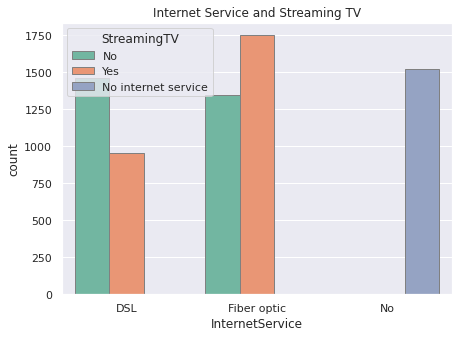

In [21]:
#インターネットサービスとストリーミングTV利用の割合を視覚化
sns.countplot(x = 'InternetService', hue = 'StreamingTV',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Internet Service and Streaming TV')

* 光ファイバー利用顧客はストリーミングTVを利用している割合が多い。
* 一方、DSL利用顧客はストリーミングTVを利用しない割合の方が多い。

Text(0.5, 1.0, 'Internet Service and Streaming Movies')

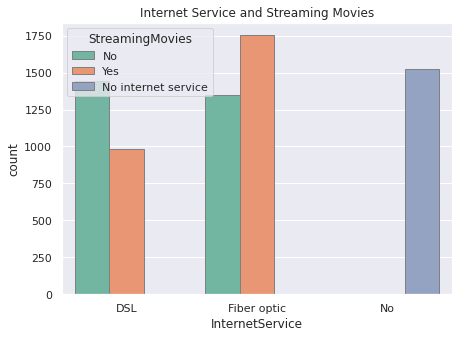

In [22]:
#インターネットサービスとストリーミング映画利用の割合を視覚化
sns.countplot(x = 'InternetService', hue = 'StreamingMovies',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Internet Service and Streaming Movies')

* 光ファイバー利用顧客はストリーミング映画を利用している割合が多い。
* 一方、DSL利用顧客はストリーミング映画を利用しない割合の方が多い。

Text(0.5, 1.0, 'Types of Contracts among the Customers')

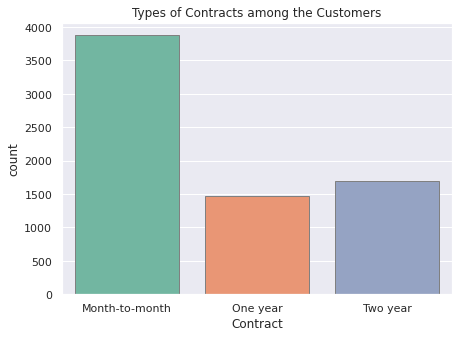

In [23]:
#契約期間の割合を視覚化
sns.countplot(x = 'Contract',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Types of Contracts among the Customers')

* 月毎の契約をしている顧客の割合が１年、２年に比べ一番多い。

Text(0.5, 1.0, 'Contract Type and Paperless Billing')

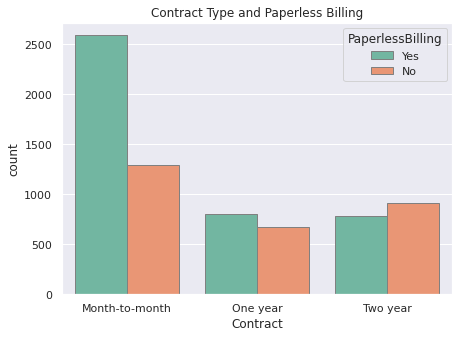

In [24]:
#契約期間とペーパーレス請求利用の割合を視覚化
sns.countplot(x = 'Contract', hue = 'PaperlessBilling',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Contract Type and Paperless Billing')

* 月毎の契約をしている顧客は、ペーパーレス請求を利用している割合が高い。

Text(0.5, 1.0, 'Contract Type and Payment Method')

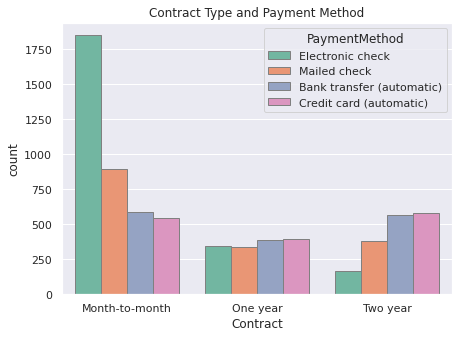

In [25]:
#契約期間と支払い方法の割合を視覚化
sns.countplot(x = 'Contract', hue = 'PaymentMethod',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Contract Type and Payment Method')

* 月毎の契約をしている顧客は電子小切手で支払う割合が一番高い。
* ２年契約をしている顧客は電子小切手ではなくクレジットカード決済を利用している割合が一番高い。

**---以下より解約者の割合を視覚化する---**

Text(0.5, 1.0, 'Churning Customers grouped by Gender')

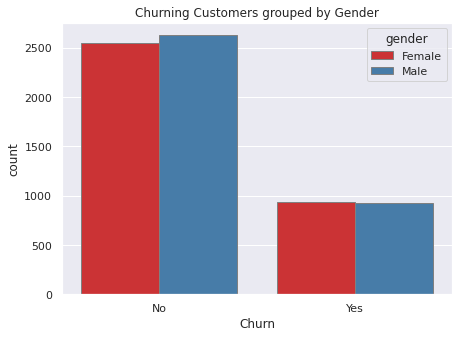

In [26]:
#解約者の性別の割合を視覚化する
sns.countplot(x = 'Churn', hue = 'gender',
              data = df, palette = 'Set1',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Churning Customers grouped by Gender')

* ほんの僅かに、女性の方が男性に比べ解約をしている。

Text(0.5, 1.0, 'Churning Customers grouped by Senior or Normal Citizens')

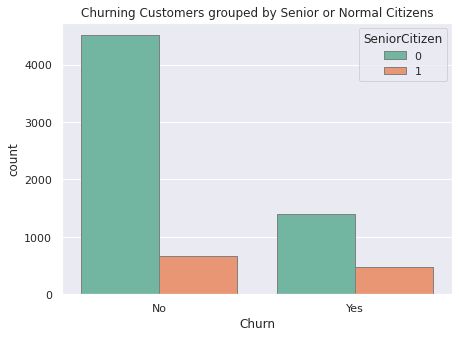

In [27]:
#解約者の高齢者の割合を視覚化
sns.countplot(x = 'Churn', hue = 'SeniorCitizen',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Churning Customers grouped by Senior or Normal Citizens')

* 高齢者では無い顧客の解約者の割合に比べ、高齢者の方が解約している割合が多い。

Text(0.5, 1.0, 'Churning Customers grouped by Customers with or without Partners')

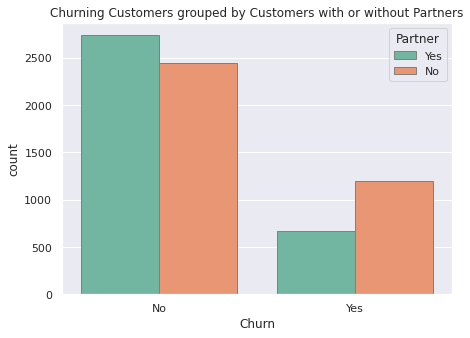

In [28]:
#解約者のパートナー有無の割合を視覚化
sns.countplot(x = 'Churn', hue = 'Partner',
              data = df, palette = 'Set2', 
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Churning Customers grouped by Customers with or without Partners')

* 解約者のうち、パートナーがいない顧客の割合がパートナーがいる顧客に比べ多い。

Text(0.5, 1.0, 'Churning Customers grouped by Dependents or No Dependents')

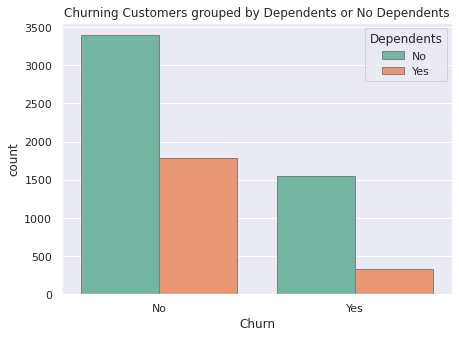

In [29]:
#解約者の扶養家族有無の割合を視覚化
sns.countplot(x = 'Churn', hue = 'Dependents',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Churning Customers grouped by Dependents or No Dependents')

* 解約者のうち、扶養家族がいない顧客の割合が扶養家族がいる顧客に比べ多い。

Text(0.5, 1.0, 'Churning Customers grouped by Customers with or without Phone Service')

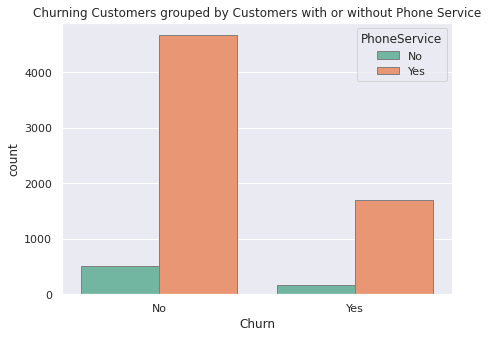

In [30]:
#解約者の電話サービス利用有無の割合を視覚化
sns.countplot(x = 'Churn', hue = 'PhoneService',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Churning Customers grouped by Customers with or without Phone Service')

* 解約者のうち、電話サービスを利用している割合の方が高い。

Text(0.5, 1.0, 'Churning Customers grouped by Customers with or without Multiple Phone Lines')

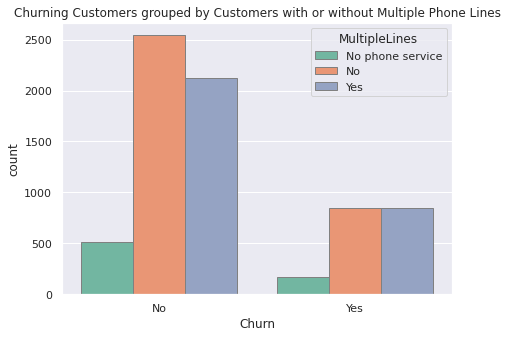

In [31]:
#解約者と複数回線利用の割合を視覚化
sns.countplot(x = 'Churn', hue = 'MultipleLines',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Churning Customers grouped by Customers with or without Multiple Phone Lines')

* 解約者のうち、複数回線利用有無に差はない。

Text(0.5, 1.0, 'Churning Customers grouped by type of Internet Service')

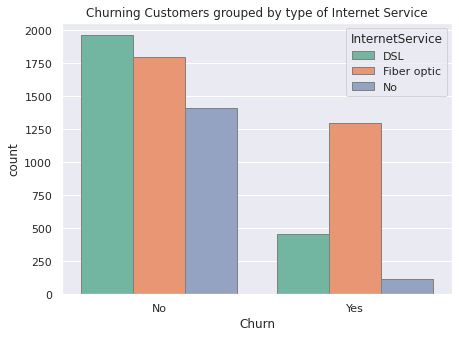

In [32]:
#解約者とインターネットサービスプロバイダーの割合を視覚化
sns.countplot(x = 'Churn', hue = 'InternetService',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Churning Customers grouped by type of Internet Service')

* 解約者のうち、光ファイバーを利用している割合が一番高い。
* 逆に解約していない顧客のうち、DSL利用顧客の割合が一番高い。

Text(0.5, 1.0, 'Churning Customers grouped by the type of Online Security')

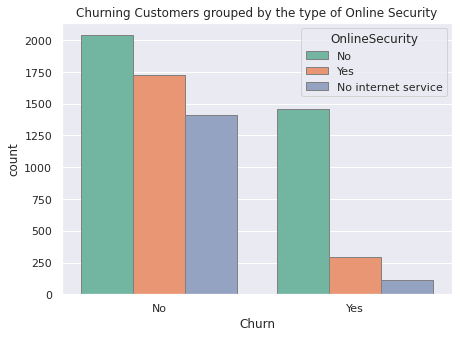

In [33]:
#解約者とオンラインセキュリティ利用の割合を視覚化
sns.countplot(x = 'Churn', hue = 'OnlineSecurity',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Churning Customers grouped by the type of Online Security')

* 解約者のうち、オンラインセキュリティを利用していない割合が一番高い。

Text(0.5, 1.0, 'Churning Customers grouped by Customers with or without Online Backup')

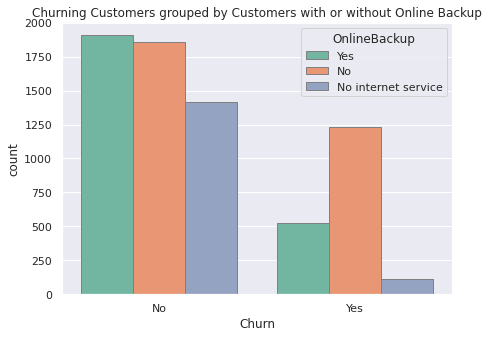

In [34]:
#解約者とオンラインバックアップ利用の割合を視覚化
sns.countplot(x = 'Churn', hue = 'OnlineBackup',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Churning Customers grouped by Customers with or without Online Backup')

* 解約者のうち、オンラインバックアップを利用していない割合が一番高い。

Text(0.5, 1.0, 'Churning Customers grouped by Customers with or without Device Protection')

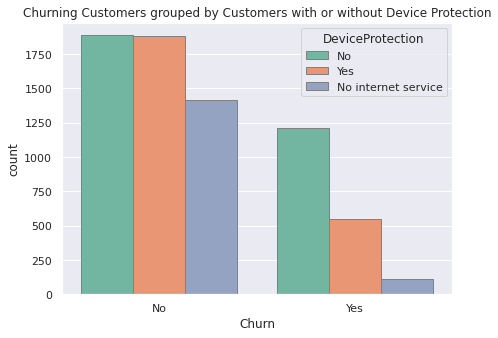

In [35]:
#解約者とデバイス保護利用の割合を視覚化
sns.countplot(x = 'Churn', hue = 'DeviceProtection',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Churning Customers grouped by Customers with or without Device Protection')

* 解約者のうち、デバイス保護を利用していない割合が一番高い。

Text(0.5, 1.0, 'Churning Customers grouped by Customers with or without Tech Support')

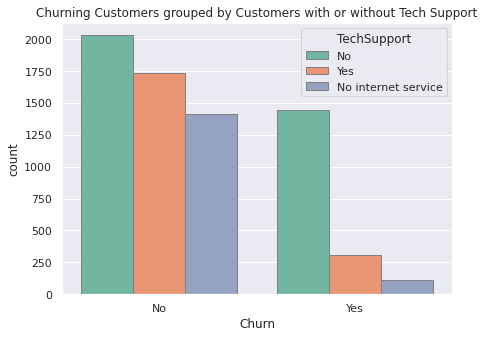

In [36]:
#解約者と技術サポート利用の割合を視覚化
sns.countplot(x = 'Churn', hue = 'TechSupport',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Churning Customers grouped by Customers with or without Tech Support')

* 解約者のうち、技術サポートを利用していない割合が一番高い。

Text(0.5, 1.0, 'Churning Customers grouped by Customers with or without Streaming TV')

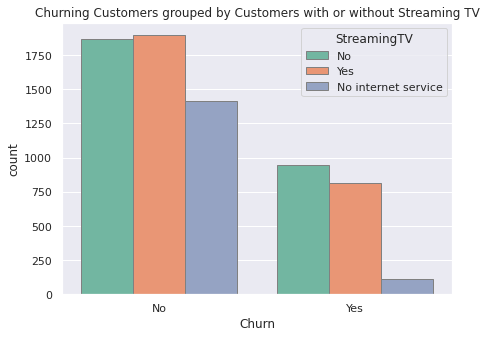

In [37]:
#解約者とストリーミングTV利用の割合を視覚化
sns.countplot(x = 'Churn', hue = 'StreamingTV',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Churning Customers grouped by Customers with or without Streaming TV')

* 解約者のうち、ストリーミングTVを利用していない顧客がほんの少し多い。

Text(0.5, 1.0, 'Churning Customers grouped by Customers with or without Streaming Movies')

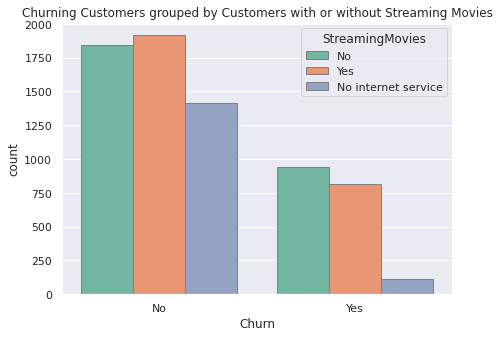

In [38]:
#解約者とストリーミング映画利用の割合を視覚化
sns.countplot(x = 'Churn', hue = 'StreamingMovies',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Churning Customers grouped by Customers with or without Streaming Movies')

* 解約者のうち、ストリーミング映画を利用していない顧客がほんの少し多い。

Text(0.5, 1.0, 'Churning Customers grouped by the Contract Type')

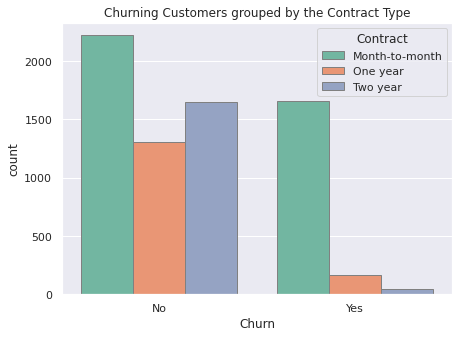

In [39]:
#解約者と契約期間の割合を視覚化
sns.countplot(x = 'Churn', hue = 'Contract',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Churning Customers grouped by the Contract Type')

* 解約者のうち、月毎の契約をしている顧客の割合が一番多い。
* 一方、２年契約をしている顧客は解約をほとんどしていない。

Text(0.5, 1.0, 'Churning Customers grouped by Customers with or without Paperless Billing')

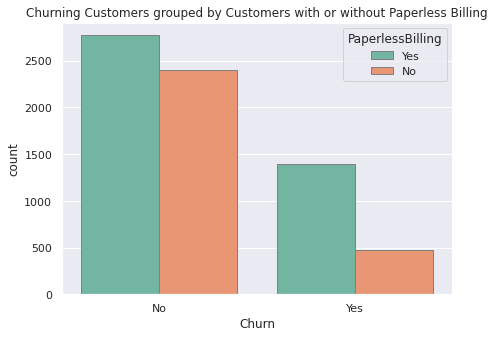

In [40]:
#解約者とペーパーレス請求の割合を視覚化
sns.countplot(x = 'Churn', hue = 'PaperlessBilling',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Churning Customers grouped by Customers with or without Paperless Billing')

* 解約者のうち、ペーパーレス請求を利用している顧客の割合が多い。

Text(0.5, 1.0, 'Churning Customers grouped by the type of Payment Method')

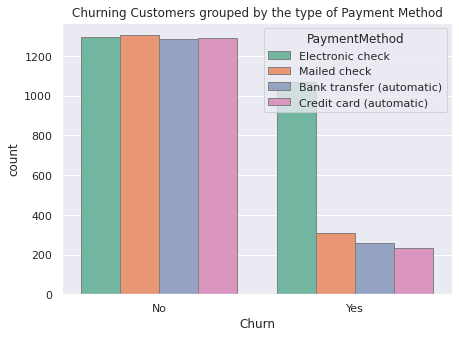

In [41]:
#解約者と支払い方法の割合を視覚化
sns.countplot(x = 'Churn', hue = 'PaymentMethod',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Churning Customers grouped by the type of Payment Method')

* 解約者のうち、電子小切手を利用している顧客の割合が一番多い。

<AxesSubplot:>

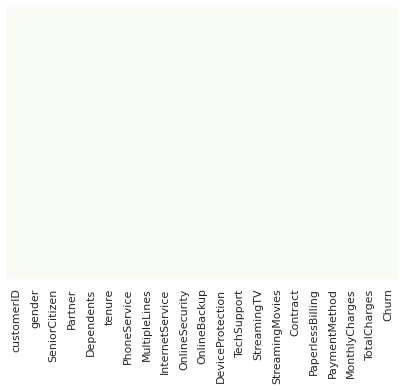

In [42]:
#不足しているものがないかヒートマップで再確認（値が出たら不足あり）
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap="Greens")

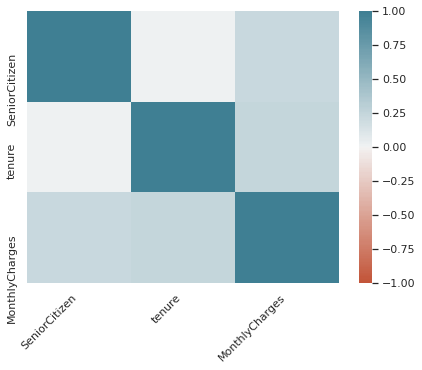

In [43]:
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200)
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# **仮説の設定**
これまでのデータ分析から、解約に繋がる要因の仮説を設定する。

* 高齢者の解約率は、非高齢者の解約率よりも高い
* パートナーがいない顧客は解約率が高い
* 扶養家族がいない顧客は解約率が高い
* インターネットサービスで光ファイバーを利用している顧客は、他のプロバイダーに比べ解約率が高い
* 支払い方法が電子小切手の顧客は、他の支払い方法の顧客よりも解約率が高い
* ペーパーレス請求をしている顧客は、していない顧客よりも解約率が高い
* 月毎の契約をしている顧客は、他の契約期間の顧客よりも解約率が高い

# **特徴量エンジニアリング**


In [44]:
#特徴量の確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [45]:
#不要なカスタマーIDの削除
df = df.drop(columns='customerID')

In [46]:
#追加サービスの特徴量を作成
df['Number_AdditionalServices'] = (df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                                       'TechSupport', 'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1) 

Text(0.5, 1.0, 'Number_AdditionalServices')

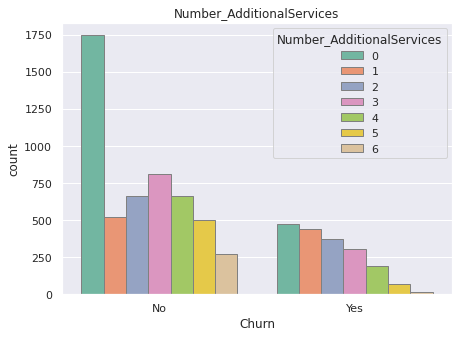

In [47]:
#解約者と追加サービスの数の割合を視覚化
sns.countplot(x = 'Churn', hue = 'Number_AdditionalServices',
              data = df, palette = 'Set2',
              edgecolor=sns.color_palette('gray', 1)
             ).set_title('Number_AdditionalServices')

* 追加サービスの数が多い顧客は解約率が低くなる。
* 追加サービスが0の顧客の解約率は非常に高い。

In [48]:
#総料金の欠落値処理
df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan).astype(float)
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace = True)

In [49]:
#2値の特徴量のラベルエンコード
features_le = ['gender', 'Partner', 'Dependents', 'Churn', 'PhoneService', 'PaperlessBilling']

def label_encoding(features, df):
    for i in features:
        df[i] = df[i].map({'Yes':1, 'No':0})
    return

label_encoding(['Partner', 'Dependents', 'Churn', 'PhoneService', 'PaperlessBilling'], df)

df['gender'] = df['gender'].map({'Female': 1, 'Male': 0})

In [50]:
#2値以上の特徴量のOne-Hotエンコーディング
features_ohe = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod', 'Number_AdditionalServices']

df = pd.get_dummies(df, columns=features_ohe)

In [51]:
#MinMaxScalerで正規化
from sklearn.preprocessing import MinMaxScaler

features_mms = ['tenure', 'MonthlyCharges', 'TotalCharges']
df_features_mms = pd.DataFrame(df, columns=features_mms)
df_remaining_features = df.drop(columns=features_mms)

mms = MinMaxScaler()
rescaled_features = mms.fit_transform(df_features_mms)

df_rescaled_features = pd.DataFrame(rescaled_features, columns=features_mms, index=df_remaining_features.index)

df = pd.concat([df_remaining_features, df_rescaled_features], axis=1)

In [52]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Number_AdditionalServices_0,Number_AdditionalServices_1,Number_AdditionalServices_2,Number_AdditionalServices_3,Number_AdditionalServices_4,Number_AdditionalServices_5,Number_AdditionalServices_6,tenure,MonthlyCharges,TotalCharges
0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0.013889,0.115423,0.001275
1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0.472222,0.385075,0.215867
2,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0.027778,0.354229,0.010310
3,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0.625000,0.239303,0.210241
4,1,0,0,0,1,1,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0.027778,0.521891,0.015330


# **テスト/トレーニングデータ分割**

In [53]:
#トレーニングデータ80%・テストデータ20%に分割する
from sklearn.model_selection import train_test_split

X1 = df.drop('Churn', axis=1)
X = X1.values
y = df['Churn'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **モデル評価指標**

<使用する指標>
* 特徴のウェイト：モデルが結果を予測する際に使用する上位と下位の特徴を示す
* 混同行列：実際の値と比較した真と偽の予測のグリッドを示す
* ROC曲線：予測の閾値の真陽性率(TPR)と偽陽性率(FPR)をまとめ、モデル予測能力を示す
* AUC：ROC曲線/PR曲線の性能を示す。（1に近いほどモデル性能が高い）
* PR曲線：偽陽性率(FPR)と偽陰性率(FNR)を比較し、モデルの予測能力を示す。
* F1スコア：適合率と再現率の調和平均を作り、両方の妥協点を測定する。

In [54]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, f1_score, plot_confusion_matrix, precision_score, recall_score

In [55]:
#特徴のウェイトをプロットする
def feature_weights(X_df, classifier, classifier_name):
    weights = pd.Series(classifier.coef_[0], index=X_df.columns.values).sort_values(ascending=False)
    
    top_weights_selected = weights[:10]
    plt.figure(figsize=(7,6))
    plt.tick_params(labelsize=10)
    plt.title(f'{classifier_name} - Top 10 Features')
    top_weights_selected.plot(kind="bar")
    
    bottom_weights_selected = weights[-10:]
    plt.figure(figsize=(7,6))
    plt.tick_params(labelsize=10)
    plt.title(f'{classifier_name} - Bottom 10 Features')
    bottom_weights_selected.plot(kind="bar")
    
    return print("")

In [56]:
#混同行列をプロットする
def confusion_matrix_plot(X_train, y_train, X_test, y_test, classifier, y_pred, classifier_name):
    fig, ax = plt.subplots(figsize=(7,6))
    plot_confusion_matrix(classifier, X_test, y_test, display_labels=["No Churn", "Churn"], cmap=plt.cm.Blues, normalize=None, ax=ax)
    ax.set_title(f'{classifier_name} - Confusion Matrix')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(7, 6))
    plot_confusion_matrix(classifier, X_test, y_test, display_labels=["No Churn", "Churn"], cmap=plt.cm.Blues, normalize='true', ax=ax)
    ax.set_title(f'{classifier_name} - Confusion Matrix (norm.)')
    plt.show()
    
    print(f'Accuracy Score Test: {accuracy_score(y_test, y_pred)}')
    print(f'Accuracy Score Train: {classifier.score(X_train, y_train)} (as comparison)')
    return print("")

In [57]:
#ROC曲線とAUCを測定する
def roc_curve_auc_score(X_test, y_test, y_pred_probabilities, classifier_name):
    
    y_pred_prob = y_pred_probabilities[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
    plt.plot([0,1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=f'{classifier_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{classifier_name} - ROC Curve')
    plt.show()
    
    return print(f'AUC Score (ROC): {roc_auc_score(y_test, y_pred_prob)}\n')

In [58]:
#PR曲線とF1スコア・AUCスコアを測定する
def precision_recall_curve_and_score(X_test, y_test, y_pred, y_pred_probabilities, classifier_name):
    
    y_pred_prob = y_pred_probabilities[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    
    plt.plot(recall, precision, label=f'{classifier_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{classifier_name} - Precision-Recall Curve')
    plt.show()
    
    f1_score_result, auc_score_result = f1_score(y_test, y_pred), auc(recall, precision)
    
    return print(f'F1 Score: {f1_score_result} \nAUC Score (PR): {auc_score_result}\n')

# **モデル作成**

# ロジスティック回帰

In [59]:
from sklearn.linear_model import LogisticRegression

#ロジスティック回帰モデルを使ってトレーニングを行う
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [60]:
#ロジスティック回帰モデルを使って予測を行う
y_pred_logreg = logreg.predict(X_test)
y_pred_logreg_prob = logreg.predict_proba(X_test)

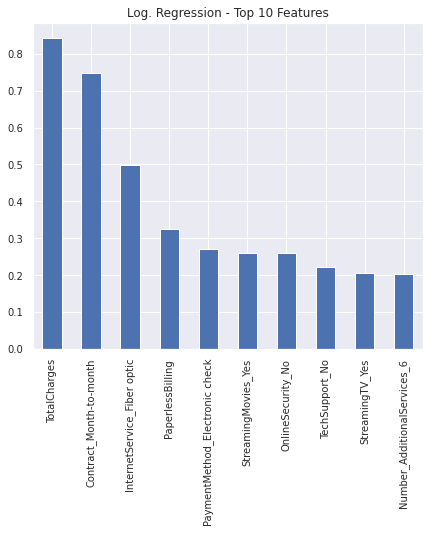

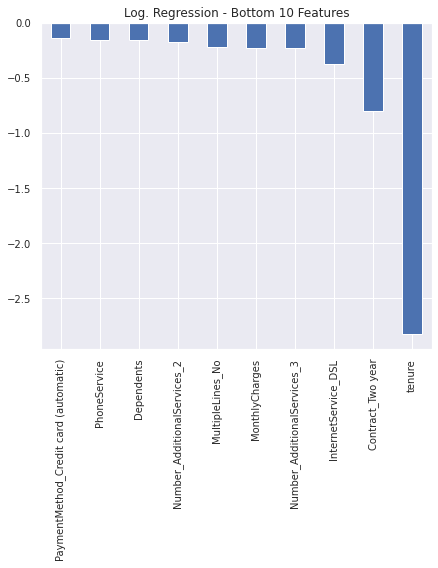

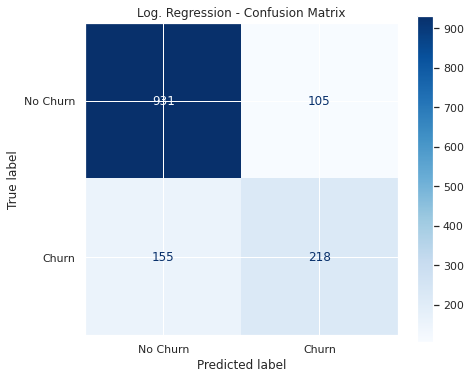

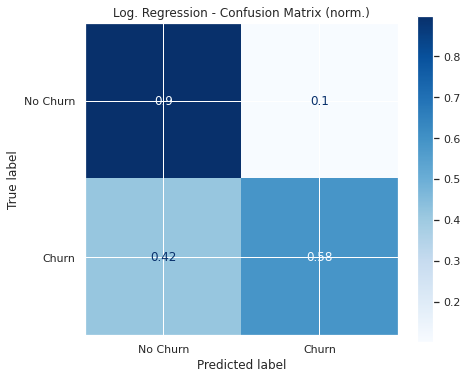

Accuracy Score Test: 0.815471965933286
Accuracy Score Train: 0.8045793397231097 (as comparison)



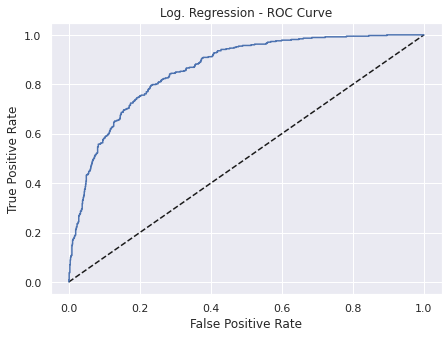

AUC Score (ROC): 0.8607489622905172



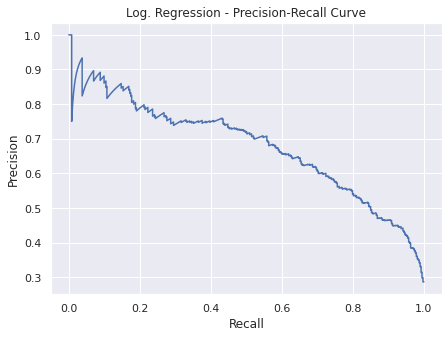

F1 Score: 0.6264367816091954 
AUC Score (PR): 0.6781961910009514



In [61]:
#モデル評価指標で表示
feature_weights(X1, logreg, 'Log. Regression')
confusion_matrix_plot(X_train, y_train, X_test, y_test, logreg, y_pred_logreg, 'Log. Regression')
roc_curve_auc_score(X_test, y_test, y_pred_logreg_prob, 'Log. Regression')
precision_recall_curve_and_score(X_test, y_test, y_pred_logreg, y_pred_logreg_prob, 'Log. Regression')

# **仮説検証**
* **高齢者の解約率は、非高齢者の解約率よりも高い**
→高齢者の特徴の重みは高くないため、一概には結論付けられない。

* **パートナーがいない顧客は解約率が高い**
→パートナー有無の特徴の重みは高くないため、一概には結論付けられない。

* **扶養家族がいない顧客は解約率が高い**
→扶養家族有無の特徴の重みは高くないため、一概には結論付けられない。

* **インターネットサービスで光ファイバーを利用している顧客は、他のプロバイダーに比べ解約率が高い**
→光ファイバー利用は解約の3番目に大きな要因のため支持される。

* **支払い方法が電子小切手の顧客は、他の支払い方法の顧客よりも解約率が高い**
→電子小切手利用は解約の5番目に大きな要因のため支持される。

* **月毎の契約をしている顧客は、他の契約期間の顧客よりも解約率が高い**
→月毎の契約は解約の2番目に大きな要因のため支持される。

* **追加サービスの数が多い顧客は解約率が低くなる。**
→追加サービス6個が解約の10番目に大きな要因のため、追加サービスの数の多さが解約率の低下に影響を与えるとは言えない。


# **まとめ**
* インターネットサービスで光ファイバーを利用している顧客の解約率が高いため、回線の遅さなどの通信サービスの質の面で考えられる。そのため、通信サービスの質を上げれば解約率が低下する可能性がある。

* 月毎の契約をしている顧客は解約率が高いため、顧客が解約や延長の決定に直面する頻度が高いほど契約の評価の機会が増えるため、顧客の解約率が高くなると考えられる。